In [2]:
import sys, os, re
sys.path.append("/awlab/users/chsu/WorkSpace/tensorflow/segmentation/code")

import numpy as np
import pandas as pd
from functools import reduce

import cv2
import matplotlib.pyplot as plt

import data_io

In [3]:
# Common paths
root_path = r'/awlab/users/chsu/WorkSpace/tensorflow/neuron'
data_root = os.path.join(root_path, 'data')
result_root = os.path.join(root_path, 'results')

file_type = '*.png'
filter_pattern = None

In [4]:
# input data
exp_name = 'adults_larvae'
img_dir = os.path.join(data_root, exp_name, 'images')
y_true_dir = os.path.join(data_root, exp_name, 'masks')
y_true_paths = data_io.get_filenames(y_true_dir, file_type, filter_pattern)

# results
def get_y_pred_path(model_name):
    y_pred_dir = os.path.join(result_root, model_name, exp_name, 'predictions')
    return data_io.get_filenames(y_pred_dir, file_type, filter_pattern)

# Compare dice loss

In [5]:
def dice_coeff(y_true, y_pred):
    intersect = np.sum((y_true > 0) & (y_pred > 0))
    d = 2. * intersect / (y_true.sum() + y_pred.sum())
    return d

def dice_loss(y_true, y_pred):
    return 1- dice_coeff(y_true, y_pred)

In [36]:
from multiprocessing import Pool
import time

n_workers = 200

def get_dl_area(path_pair):
    """path_pair: (y_true_path, y_pred_path)"""
    y_pred = cv2.imread(path_pair[1])[...,0] / 255.
    y_pred = np.float64(y_pred > 0.5)
    
    y_true = cv2.imread(path_pair[0])[...,0] / 255.
    if y_true.shape != y_pred.shape:
        y_true = cv2.resize(y_true, (y_pred.shape[1], y_pred.shape[0]))
    
    DL = dice_loss(y_true, y_pred)
    area_pred = y_pred.sum()
    area_true = y_true.sum()
    fname = os.path.basename(path_pair[1])
    
    return DL, area_true, area_pred, fname


def get_model_results(model_name):
    print("Retrieving results of {}...".format(model_name))
    
    y_pred_paths = get_y_pred_path(model_name)
    
    # check y_true_paths and y_pred_paths have the same file names
    assert [os.path.basename(f) for f in y_true_paths] == \
           [os.path.basename(f) for f in y_pred_paths], 'y_true and y_pred must have same file names'
    
    path_pairs = zip(y_true_paths, y_pred_paths)
    n_tasks = len(y_pred_paths)
    
    with Pool(n_workers) as p:
        results = []
        for i, r in enumerate(p.imap(get_dl_area, path_pairs), 1):
            results.append(r)
            print("  Done {}/{}".format(i, n_tasks), end='\r')
    
    return results


def results_to_dataframe(results, tag='', **kwargs):
    DL, area_true, area_pred, file_names = zip(*results)
    
    # Get well, column, row, frame, time from file name
    pattern = re.compile('^(?P<type>(Adults|Larvae))_.*\.png$')
    metadata = [pattern.search(f).groupdict() for f in file_names]
    
    # Construct dataframe
    df = pd.DataFrame(metadata)
    df['dice_loss'] = DL
    df['area_true'] = area_true
    df['area_pred'] = area_pred
    df['file_name'] = file_names
    df = df[['file_name', 'type', 'area_true', 'dice_loss', 'area_pred']]
    
    # Add tag to column names
    if tag is not '':
        df = df.rename(columns={'dice_loss': 'dice_loss' + tag, 
                                'area_pred': 'area_pred' + tag})
    
    return df
    

def get_result_df(model_name, **kwargs):
    return results_to_dataframe(get_model_results(model_name), **kwargs)
    

In [41]:
# Construct result dataframes fro each model
start = time.time()

model_names = ['adult_062019', 'adult_larvae_062019', 'AL_uw_small']
tags = ['_A', '_AL', '_ALs']

dfs = [get_result_df(m, tag=t) for (m, t) in zip(model_names, tags)]

# Merge all dataframes
df = reduce(lambda x, y: pd.merge(x, y, on=['file_name', 'type', 'area_true'], 
                                  suffixes=(False, False)), dfs)
del dfs

print("  Done (Time elapsed: {}s)".format(int(time.time() - start)))

Retrieving results of adult_062019...
Retrieving results of adult_larvae_062019...
Retrieving results of AL_uw_small...
  Done (Time elapsed: 6s)


In [68]:
df.head()

,file_name,type,area_true,dice_loss_A,area_pred_A,dice_loss_AL,area_pred_AL,dice_loss_ALs,area_pred_ALs
0,Adults_10_c.png,Adults,11572.0,0.129487,11079.0,0.176686,13014.0,0.159521,11403.0
1,Adults_10_m.png,Adults,9315.0,0.121043,9323.0,0.162354,10586.0,0.147294,9294.0
2,Adults_11_c.png,Adults,9731.0,0.106716,9329.0,0.136002,10482.0,0.134283,9363.0
3,Adults_11_m.png,Adults,10913.0,0.141366,11129.0,0.189536,13056.0,0.166636,11135.0
4,Adults_12_c.png,Adults,9418.0,0.121330,9283.0,0.168474,10312.0,0.156277,9318.0


In [69]:
df.loc[df['area_true']==31]

,file_name,type,area_true,dice_loss_A,area_pred_A,dice_loss_AL,area_pred_AL,dice_loss_ALs,area_pred_ALs
170,Larvae_021219_Series089_2.png,Larvae,31.0,1.0,18.0,1.000000,16.0,1.000000,32.0
171,Larvae_021219_Series101_2.png,Larvae,31.0,1.0,8.0,0.673469,18.0,0.686275,20.0


# Visualization

<IPython.core.display.Javascript object>


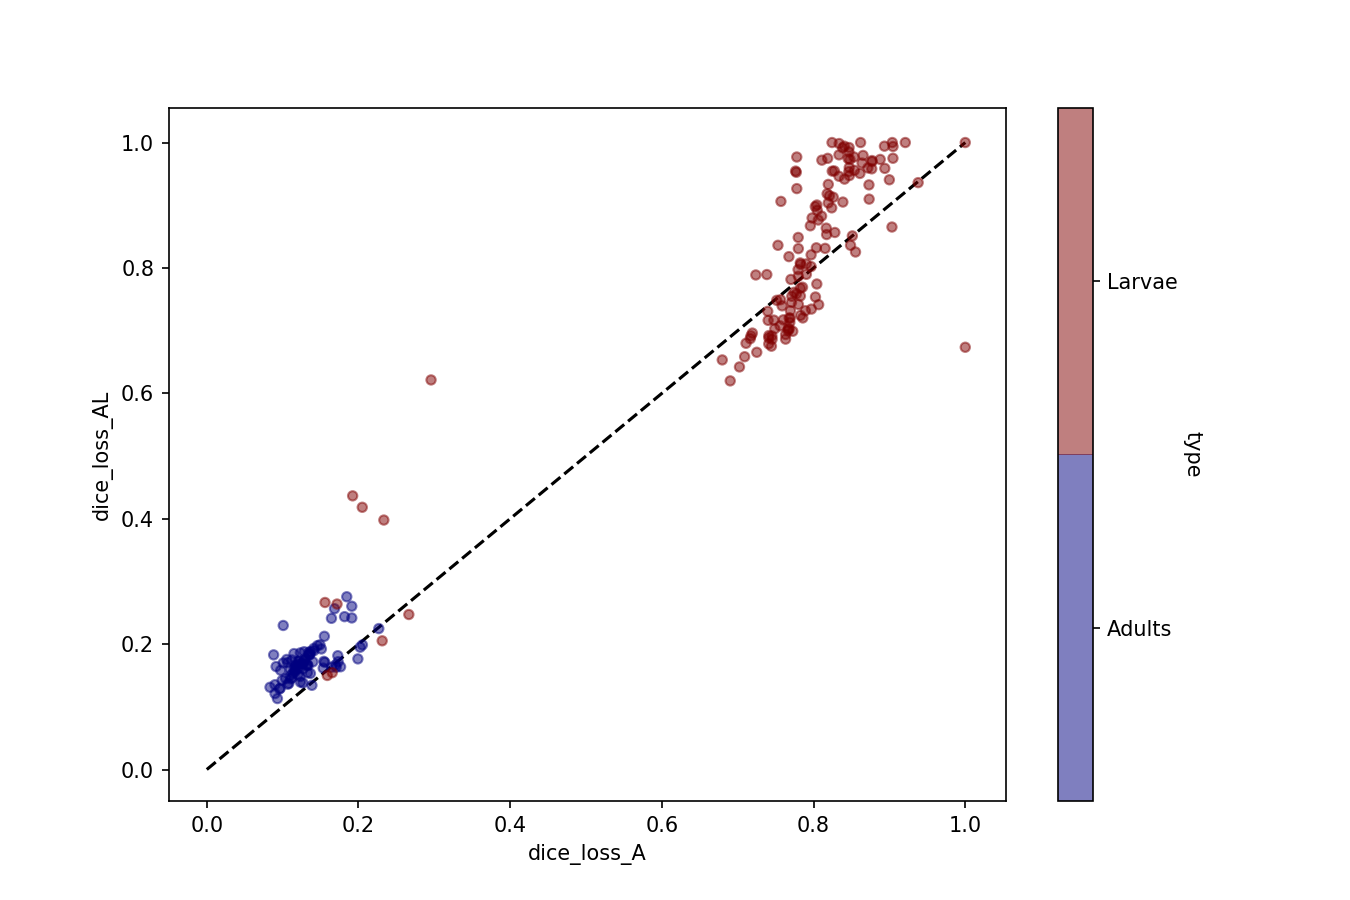

In [67]:
%matplotlib notebook

x_val = 'dice_loss_A'
y_val = 'dice_loss_AL'
clr_key = 'type'


clr_grp = df[clr_key].astype('category').cat.categories
clr_idx = df[clr_key].astype('category').cat.codes

ax = df.plot.scatter(x=x_val, y=y_val, style='.', alpha=0.5,
                     c=clr_idx, vmin=-0.5, vmax=len(clr_grp)-0.5,
                     cmap=plt.cm.get_cmap("jet", len(clr_grp)),
                     figsize=(9,6))
fig = ax.get_figure()
line = ax.collections[0]

annot = ax.annotate("", xy=(0,0), xytext=(-20,10), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"), arrowprops=dict(arrowstyle="->"), zorder=100)
annot.set_visible(False)

def update_annot(ind):
    idx = ind["ind"][0]
    
    # for scatter
    pos = line.get_offsets()
    annot.xy = pos[idx]
    
    file_name = df.loc[idx,'file_name']
    area = df.loc[idx,'area_true']
    x = df.loc[idx,x_val]
    y = df.loc[idx,y_val]
    text = "{}\nArea: {area:d}\n{x_val:}: {x:.2f}\n{y_val:}: {y:.2f}".format(
        file_name, area=int(area), x_val=x_val, x=x, y_val=y_val, y=y)

    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(1)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = line.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

# set colorbar
cb_ax = fig.axes[1]
cb_ax.yaxis.set_ticks(range(len(clr_grp)))
cb_ax.set_yticklabels(clr_grp)
cb_ax.set_ylabel(clr_key, rotation=270, verticalalignment='baseline')
cb_ax.zorder = -1

# Overlay diagnal for comparing dice loss
if 'dice_loss' in x_val and 'dice_loss' in y_val:
    ax.plot([0, 1], [0, 1], 'k--', zorder=-1)

plt.show()


# Test ground

In [ ]:
area_rng = (df['area'] > 200000) & (df['area'] < 300000)
dl_rng = df['dice_loss'] > 0.35
to_check = area_rng & dl_rng

df_check = df[to_check].copy().reset_index(drop=True)
df_check.head()

In [ ]:
def show_overlay(f):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12,16))
    plt.imshow(img)
    plt.title(os.path.basename(f))

In [ ]:
%matplotlib notebook
show_overlay(df_check.loc[0,'file'])

In [ ]:
df.hist('dice_loss')

In [ ]:
%matplotlib inline
f = df.loc[0, 'file']
img = cv2.imread(f)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,16))
plt.imshow(img)
plt.title(os.path.basename(f))

In [ ]:
img = np.random.rand(1000,1000)*255.
print(img.shape)
cv2.imwrite('test.png', np.uint8(img))